In [1]:
# loading and pre-processing data

import os
import cv2

datadir = '/Users/norafaf/Desktop/Brain Tumor Data Set'
categories = ["Brain Tumor","Healthy"] 
dataset = []   
img_size = 150

for category in categories:
    path = os.path.join(datadir,category)
    class_num = categories.index(category)

    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array,(img_size,img_size))
            dataset.append([new_array,class_num])
        except Exception as e:
            pass

print("Total images ->",len(dataset))

Total images -> 5026


In [2]:
# re-shaping and normalizing

import numpy as np

X = []
y = []

for features,label in dataset:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1,img_size,img_size,1)
X = X/255.0
y = np.array(y).reshape(-1,1)

print("Dimension of input features ->",X.shape)
print("Dimension of output labels ->",y.shape)

Dimension of input features -> (5026, 150, 150, 1)
Dimension of output labels -> (5026, 1)


In [3]:
# train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print("X_train shape ->",X_train.shape)
print("X_test shape ->",X_test.shape)
print("y_train shape ->",y_train.shape)
print("y_test shape ->",y_test.shape)

X_train shape -> (4020, 150, 150, 1)
X_test shape -> (1006, 150, 150, 1)
y_train shape -> (4020, 1)
y_test shape -> (1006, 1)


In [4]:
# building model architecture

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping


#data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

model = Sequential()

# 1st conv layer block
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'same', activation ='relu', 
                 input_shape = (150,150,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# 2nd conv layer block
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

# 3rd conv layer block
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# 4th conv layer block
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# 5th conv layer block
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# fullly-connected layers
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = "sigmoid"))


# compiling the model
model.compile(optimizer = 'adam' , loss = "binary_crossentropy",metrics=["accuracy"])



In [6]:
# training the model

from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train,y_train,
    batch_size = 50,
    epochs = 5,
    callbacks=[reduce_lr,early_stop,checkpoint], 
    validation_split = 0.2
)

Epoch 1/5
65/65 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5302

/Users/norafaf/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 530s 8s/step - loss: 0.6872 - accuracy: 0.5302 - val_loss: 0.6608 - val_accuracy: 0.5883 - lr: 0.0010
Epoch 2/5
65/65 [==============================] - 568s 9s/step - loss: 0.5687 - accuracy: 0.7002 - val_loss: 0.4802 - val_accuracy: 0.7898 - lr: 0.0010
Epoch 3/5
65/65 [==============================] - 521s 8s/step - loss: 0.4723 - accuracy: 0.7823 - val_loss: 0.4227 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 4/5
65/65 [==============================] - 488s 7s/step - loss: 0.3942 - accuracy: 0.8246 - val_loss: 0.3830 - val_accuracy: 0.8545 - lr: 0.0010
Epoch 5/5
65/65 [==============================] - 482s 7s/step - loss: 0.3421 - accuracy: 0.8560 - val_loss: 0.3050 - val_accuracy: 0.8806 - lr: 0.0010


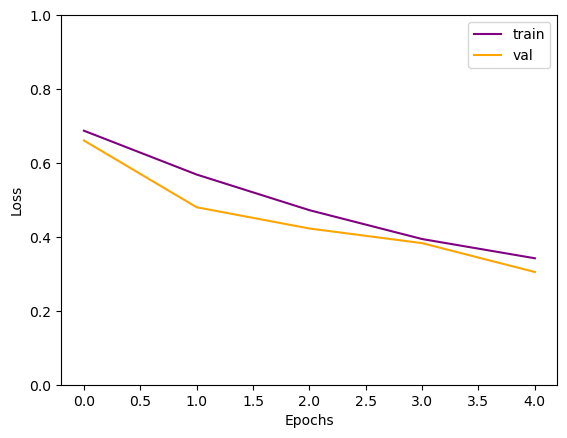

In [7]:
# plotting training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history["loss"],c = "purple")
plt.plot(history.history["val_loss"],c = "orange")
plt.ylim([0,1])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

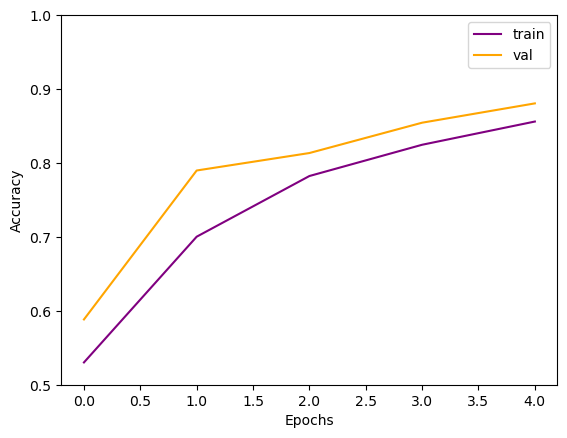

In [8]:
# plotting training and validation accuracy

plt.plot(history.history["accuracy"],c = "purple")
plt.plot(history.history["val_accuracy"],c = "orange")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.xlabel("Epochs")
plt.legend(["train", "val"])
plt.show()

In [9]:
# evaluating the model on test dataset

import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

loss, accuracy = model.evaluate(X_test,y_test,verbose=0)

y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')
print(f'Test precision: {precision:.4f}')
print(f'Test recall: {recall:.4f}')
print(f'Test F1 score: {f1:.4f}')

32/32 [==============================] - 47s 1s/step
Test loss: 0.2565
Test accuracy: 0.8986
Test precision: 0.9442
Test recall: 0.8460
Test F1 score: 0.8924


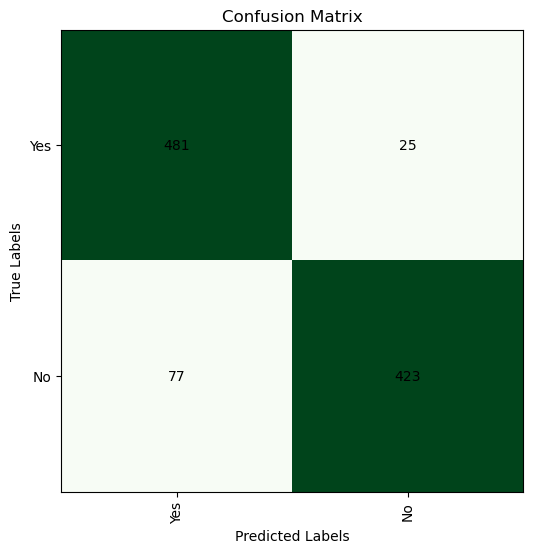

In [10]:
# plotting the confusion matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.title('Confusion Matrix')
plt.imshow(conf_matrix, cmap=plt.cm.Greens,vmin=240,vmax=370)

tick_marks = range(conf_matrix.shape[0])
classes = ['Yes', 'No']
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

for i in range(0,2):
    for j in range(0,2):
        plt.text(
            j, i, str(conf_matrix[i][j]),
            horizontalalignment="center",
            verticalalignment="center"
        )

In [11]:
# loading and pre-processing unlabelled images

datadir = '/Users/norafaf/Desktop/Brain Tumor Data Set'
path = os.path.join(datadir,'training')
X_new = []
img_size = 150


for img in os.listdir(path):
    try:
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(img_size,img_size))
        X_new.append(new_array)
    except Exception as e:
        pass

X_new = np.array(X_new).reshape(-1,img_size,img_size,1)
X_new = X_new/255.0

print("Total unlabelled images ->",len(X_new))
print("Dimensions after pre-processing ->",X_new.shape)


Total unlabelled images -> 105
Dimensions after pre-processing -> (105, 150, 150, 1)


4/4 [==============================] - 4s 892ms/step


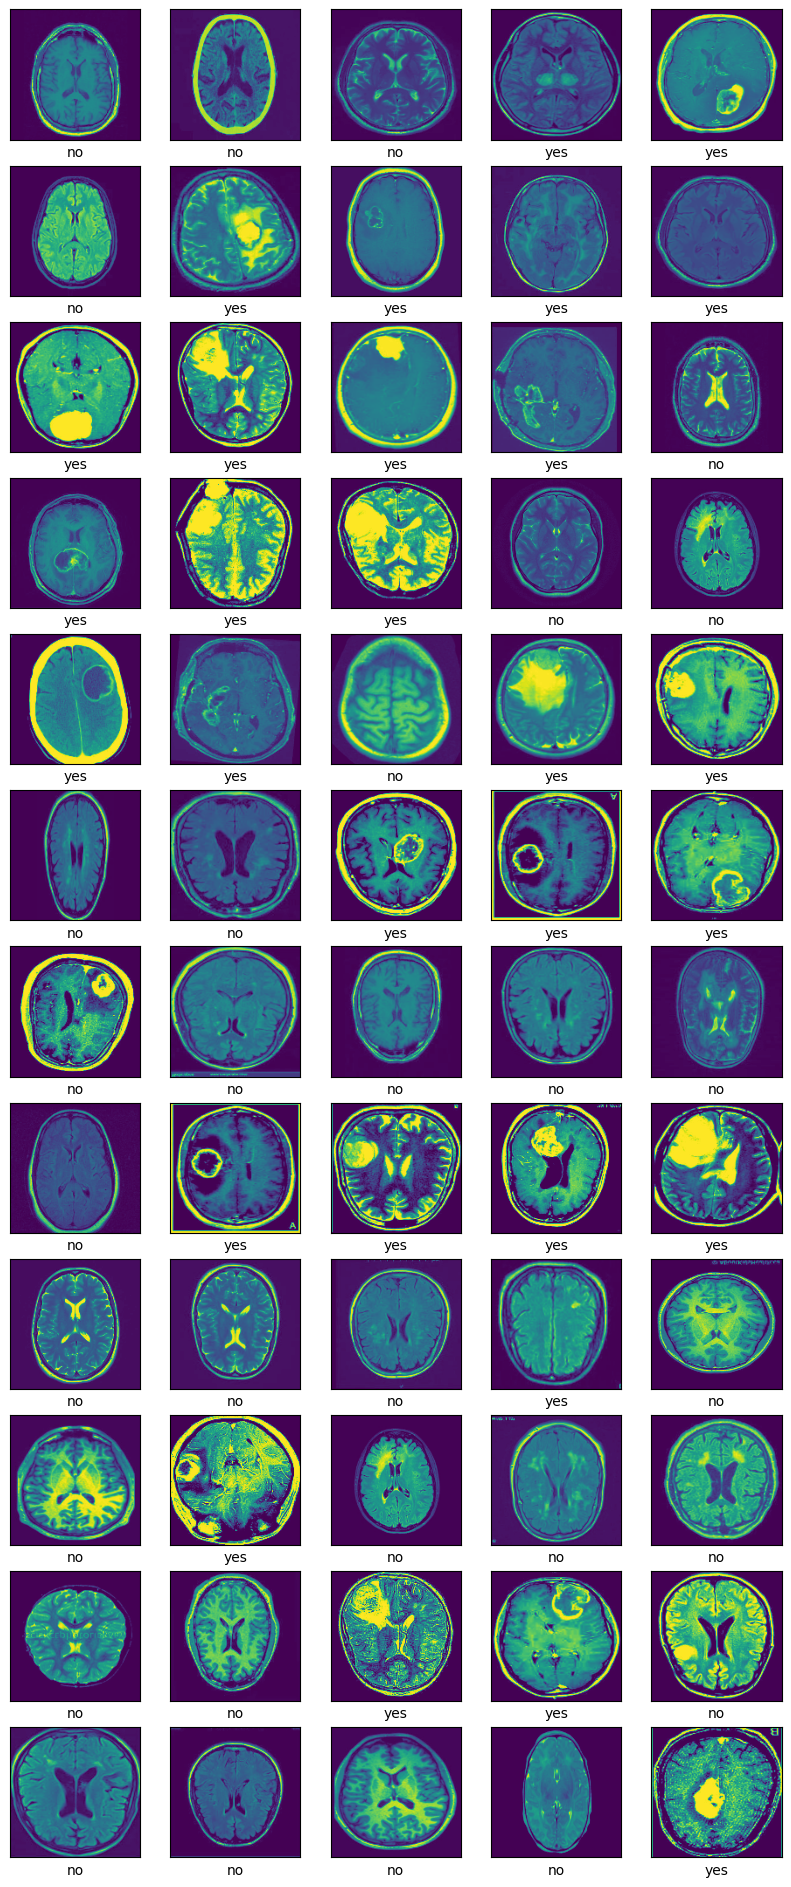

In [12]:
# making predictions

y_pred_new = model.predict(X_new)
y_pred_new = (y_pred_new >= 0.5).astype(int)

categories = ["yes","no"]

plt.figure(figsize=(10,24))
for i in range(60):
    plt.subplot(12,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_new[i])
    plt.xlabel(categories[y_pred_new[i][0]])
    